In [4]:
# ===================================================================
# Block 1: Imports & Configuration
# ===================================================================
import os
import random
import joblib
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import optuna
import shap
from pathlib import Path
from datetime import datetime
import logging

# Technical Analysis & ML Libraries
from ta.trend import MACD, SMAIndicator
from ta.momentum import RSIIndicator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- Configuration ---
RANDOM_SEED = 42
START_DATE = "2010-01-01"
END_DATE = "2025-05-31"
TARGET_TICKER = "^JKSE"
SEQUENCE_LENGTH = 60
TRAIN_SPLIT = 0.8
BATCH_SIZE = 32
EPOCHS = 100
PATIENCE = 10
N_TRIALS_LSTM = 20
N_TRIALS_XGB = 30
TICKERS = [
    "^JKSE", "^GSPC", "^IXIC", "BZ=F", "CL=F", "GC=F", "SI=F",
    "NG=F", "HG=F", "^GDAXI", "GBPUSD=X", "EURUSD=X", "USDIDR=X"
]

# --- Initial Setup ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Force TensorFlow to use CPU only
tf.config.set_visible_devices([], 'GPU')
print("Block 1: Setup and Configuration Complete.")

# ===================================================================
# Block 2: Data Acquisition
# ===================================================================
logging.info("Fetching market data...")
market_data = yf.download(TICKERS, start=START_DATE, end=END_DATE, progress=False)
df_close = market_data['Close']

logging.info("Fetching Federal Funds Rate...")
fed_funds = web.DataReader('FEDFUNDS', 'fred', START_DATE, END_DATE)

raw_df = df_close.join(fed_funds, how='outer')
logging.info("Data fetching complete.")
print("\nBlock 2: Data Acquisition Complete.")
print("Raw Data Head:")
print(raw_df.head())

# ===================================================================
# Block 3: Feature Engineering
# ===================================================================
logging.info("Starting feature engineering...")
feature_df = raw_df.copy()

# Technical Indicators
feature_df[f'{TARGET_TICKER}_SMA10'] = SMAIndicator(feature_df[TARGET_TICKER], window=10).sma_indicator()
feature_df[f'{TARGET_TICKER}_RSI14'] = RSIIndicator(feature_df[TARGET_TICKER], window=14).rsi()
macd = MACD(feature_df[TARGET_TICKER])
feature_df[f'{TARGET_TICKER}_MACD'] = macd.macd()
feature_df[f'{TARGET_TICKER}_MACD_Signal'] = macd.macd_signal()

# Lag features
for lag in range(1, 4):
    feature_df[f'{TARGET_TICKER}_lag_{lag}'] = raw_df[TARGET_TICKER].shift(lag)

# Cyclical features
feature_df['DayOfWeek'] = raw_df.index.dayofweek
feature_df['Month'] = raw_df.index.month

# Fill NaNs
feature_df = feature_df.fillna(method='bfill').fillna(method='ffill')
logging.info("Feature engineering complete.")
print("\nBlock 3: Feature Engineering Complete.")
print("Feature Data Head:")
print(feature_df.head())



2025-07-06 18:56:19,105 - INFO - Fetching market data...


Block 1: Setup and Configuration Complete.


2025-07-06 18:56:20,469 - INFO - Fetching Federal Funds Rate...
2025-07-06 18:56:20,562 - INFO - Data fetching complete.
2025-07-06 18:56:20,571 - INFO - Starting feature engineering...
2025-07-06 18:56:20,581 - INFO - Feature engineering complete.



Block 2: Data Acquisition Complete.
Raw Data Head:
                 BZ=F       CL=F  EURUSD=X  GBPUSD=X         GC=F    HG=F  \
2010-01-01        NaN        NaN  1.438994  1.613294          NaN     NaN   
2010-01-04  80.120003  81.510002  1.442398  1.611370  1117.699951  3.3880   
2010-01-05  80.589996  81.769997  1.436596  1.599079  1118.099976  3.3960   
2010-01-06  81.889999  83.180000  1.440403  1.602384  1135.900024  3.4775   
2010-01-07  81.510002  82.660004  1.431803  1.593397  1133.099976  3.4115   

             NG=F       SI=F     USDIDR=X       ^GDAXI        ^GSPC  \
2010-01-01    NaN        NaN  9385.599609          NaN          NaN   
2010-01-04  5.884  17.440001  9364.200195  6048.299805  1132.989990   
2010-01-05  5.637  17.781000  9305.200195  6031.859863  1136.520020   
2010-01-06  6.009  18.163000  9218.099609  6034.330078  1137.140015   
2010-01-07  5.806  18.333000  9272.500000  6019.359863  1141.689941   

                  ^IXIC        ^JKSE  FEDFUNDS  
2010-01-0

In [ ]:
# ===================================================================
# Block 4: Stationarity Test and Transformation
# ===================================================================
logging.info(f"Performing stationarity test on '{TARGET_TICKER}'...")
series = feature_df[TARGET_TICKER].dropna()
was_differenced = False

if series.empty:
    logging.warning(f"The series for '{TARGET_TICKER}' is empty after dropping NaNs. Skipping stationarity test.")
    print(f"\nWarning: Stationarity test skipped because the data series for {TARGET_TICKER} is empty.")
else:
    result = adfuller(series)
    print('\n--- Augmented Dickey-Fuller Test (Original Data) ---')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    if result[1] > 0.05:
        print("\nResult: The series is likely non-stationary. Applying first-order differencing.")
        was_differenced = True
        
        # Store the last value of the original series for inverse differencing later
        last_original_value = feature_df[TARGET_TICKER].iloc[-1]
        
        # Apply differencing
        feature_df = feature_df.diff().dropna()
        
        # Re-test the differenced series
        series_diff = feature_df[TARGET_TICKER].dropna()
        result_diff = adfuller(series_diff)
        print('\n--- Augmented Dickey-Fuller Test (Differenced Data) ---')
        print(f'ADF Statistic: {result_diff[0]:.4f}')
        print(f'p-value: {result_diff[1]:.4f}')
        if result_diff[1] <= 0.05:
            print("\nResult: The differenced series is now likely stationary.")
        else:
            print("\nWarning: The series is still non-stationary after differencing.")
    else:
        print("\nResult: The series is likely stationary (p-value <= 0.05). No transformation needed.")
    print('-------------------------------------\n')

print("Block 4: Stationarity Test Complete.")

2025-07-06 18:56:31,670 - INFO - Performing stationarity test on '^JKSE'...



--- Augmented Dickey-Fuller Test ---
ADF Statistic: -1.8929
p-value: 0.3354
Critical Values:
	1%: -3.4320
	5%: -2.8623
	10%: -2.5671

Result: The series is likely non-stationary (p-value > 0.05).
-------------------------------------

Block 4: Stationarity Test Complete.


In [6]:
# ===================================================================
# Block 5: Data Preparation
# ===================================================================
logging.info("Preparing data with correct scaling procedure...")
target_col_index = feature_df.columns.get_loc(TARGET_TICKER)

# 1. Split the dataframe first
train_size = int(len(feature_df) * TRAIN_SPLIT)
train_df = feature_df.iloc[:train_size]
test_df = feature_df.iloc[train_size:]

# 2. Fit the scaler ONLY on the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_df)

# 3. Transform both training and testing data
train_scaled = scaler.transform(train_df)
test_scaled = scaler.transform(test_df)

# 4. Create sequences from the correctly scaled data
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(seq_length, len(data)):
        xs.append(data[i-seq_length:i, :])
        ys.append(data[i, target_col_index])
    return np.array(xs), np.array(ys)

X_train_seq, y_train = create_sequences(train_scaled, SEQUENCE_LENGTH)

combined_test_data = np.vstack((train_scaled[-(SEQUENCE_LENGTH):], test_scaled))
X_test_seq, y_test = create_sequences(combined_test_data, SEQUENCE_LENGTH)

# 5. Get the non-sequenced features for the residual model
X_train_flat = np.delete(train_scaled[SEQUENCE_LENGTH:], target_col_index, axis=1)
X_test_flat = np.delete(test_scaled, target_col_index, axis=1)

logging.info(f"Data prepared: LSTM Train Shape={X_train_seq.shape}, XGBoost Train Shape={X_train_flat.shape}")
logging.info(f"LSTM Test Shape={X_test_seq.shape}, XGBoost Test Shape={X_test_flat.shape}")
print("\nBlock 5: Data Preparation Complete.")

2025-07-06 18:56:31,931 - INFO - Preparing data with correct scaling procedure...
2025-07-06 18:56:32,004 - INFO - Data prepared: LSTM Train Shape=(3197, 60, 23), XGBoost Train Shape=(3197, 22)
2025-07-06 18:56:32,005 - INFO - LSTM Test Shape=(815, 60, 23), XGBoost Test Shape=(815, 22)



Block 5: Data Preparation Complete.


In [ ]:
# ===================================================================
# Block 6: LSTM Model Optimization and Training
# ===================================================================
def create_lstm_model(hp, input_shape):
    model = Sequential([
        LSTM(units=hp.suggest_int('units', 32, 128, step=16), return_sequences=False, input_shape=input_shape),
        Dropout(hp.suggest_float('dropout', 0.1, 0.5, step=0.1)),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.suggest_float('learning_rate', 1e-4, 1e-2, log=True)), loss='mean_squared_error')
    return model

def lstm_objective(trial):
    model = create_lstm_model(trial, (X_train_seq.shape[1], X_train_seq.shape[2]))
    val_split_index = int(len(X_test_seq) * 0.5)
    X_val, y_val = X_test_seq[:val_split_index], y_test[:val_split_index]
    trial_callbacks = [EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)]
    history = model.fit(X_train_seq, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=trial_callbacks, verbose=1)
    return min(history.history['val_loss'])

logging.info("Optimizing LSTM model...")
lstm_study = optuna.create_study(direction='minimize')
# lstm_study.optimize(lstm_objective, n_trials=N_TRIALS_LSTM, n_jobs=-1)
lstm_study.optimize(lstm_objective, n_trials=N_TRIALS_LSTM, n_jobs=1)

logging.info(f"Best LSTM trial: {lstm_study.best_trial.params}")
lstm_model = create_lstm_model(lstm_study.best_trial, (X_train_seq.shape[1], X_train_seq.shape[2]))
final_callbacks = [ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, min_lr=1e-6), ModelCheckpoint(filepath='best_lstm_model.keras', save_best_only=True, monitor='loss', mode='min')]

logging.info("Training the final best LSTM model...")
lstm_model.fit(X_train_seq, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, callbacks=final_callbacks)
lstm_model = tf.keras.models.load_model('best_lstm_model.keras')
print("\nBlock 6: LSTM Training Complete.")


2025-07-06 18:56:32,041 - INFO - Optimizing LSTM model...
[I 2025-07-06 18:56:32,043] A new study created in memory with name: no-name-4d5ac6d5-4ff4-4de9-ae1e-340eb851a00f


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0397 - val_loss: 0.0021 - learning_rate: 1.6354e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0074 - val_loss: 9.2921e-04 - learning_rate: 1.6354e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0049 - val_loss: 4.0740e-04 - learning_rate: 1.6354e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0038 - val_loss: 4.0149e-04 - learning_rate: 1.6354e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0034 - val_loss: 3.4814e-04 - learning_rate: 1.6354e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0030 - val_loss: 3.9791e-04 - learning_rate: 1.6354e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0025 - val_loss: 4.6024e-04 - learning_rate: 1.6354e-04
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0024 - val_loss: 4.9281e-04 - learning_rate: 1.6354e-04
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s

[I 2025-07-06 19:01:55,832] Trial 0 finished with value: 0.00028177181957289577 and parameters: {'units': 128, 'dropout': 0.2, 'learning_rate': 0.0001635380108885046}. Best is trial 0 with value: 0.00028177181957289577.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.1995 - val_loss: 0.0019 - learning_rate: 0.0056
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0040 - val_loss: 8.5077e-04 - learning_rate: 0.0056
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0028 - val_loss: 0.0018 - learning_rate: 0.0056
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0022 - val_loss: 2.5502e-04 - learning_rate: 0.0056
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0019 - val_loss: 0.0021 - learning_rate: 0.0056
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0016 - val_loss: 3.5190e-04 - learning_rate: 0.0056
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0018 - val_loss: 2.4591e-04 - learning_rate: 0.0056
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0016 - val_loss: 0.0011 - learning_rate: 0.0056
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0014 - val_loss: 2.0263e

[I 2025-07-06 19:03:50,497] Trial 1 finished with value: 0.00020048354053869843 and parameters: {'units': 96, 'dropout': 0.2, 'learning_rate': 0.005554643042863346}. Best is trial 1 with value: 0.00020048354053869843.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.1429 - val_loss: 0.0073 - learning_rate: 1.7089e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0108 - val_loss: 0.0087 - learning_rate: 1.7089e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0096 - val_loss: 0.0060 - learning_rate: 1.7089e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0068 - val_loss: 0.0016 - learning_rate: 1.7089e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0056 - val_loss: 5.0699e-04 - learning_rate: 1.7089e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0047 - val_loss: 4.3688e-04 - learning_rate: 1.7089e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0043 - val_loss: 4.0980e-04 - learning_rate: 1.7089e-04
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0037 - val_loss: 0.0011 - learning_rate: 1.7089e-04
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss

[I 2025-07-06 19:04:50,750] Trial 2 finished with value: 0.0004097960772924125 and parameters: {'units': 64, 'dropout': 0.1, 'learning_rate': 0.00017089211278762753}. Best is trial 1 with value: 0.00020048354053869843.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0838 - val_loss: 0.0071 - learning_rate: 8.2485e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0074 - val_loss: 0.0011 - learning_rate: 8.2485e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0040 - val_loss: 0.0048 - learning_rate: 8.2485e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0035 - val_loss: 0.0053 - learning_rate: 8.2485e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0027 - val_loss: 0.0014 - learning_rate: 8.2485e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0021 - val_loss: 0.0041 - learning_rate: 8.2485e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0020 - val_loss: 0.0034 - learning_rate: 8.2485e-04
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0019 - val_loss: 0.0037 - learning_rate: 1.6497e-04
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0018 - v

[I 2025-07-06 19:05:32,354] Trial 3 finished with value: 0.0011236052960157394 and parameters: {'units': 48, 'dropout': 0.1, 'learning_rate': 0.0008248484463455086}. Best is trial 1 with value: 0.00020048354053869843.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 0.0574 - val_loss: 8.1157e-04 - learning_rate: 0.0028
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0060 - val_loss: 5.6441e-04 - learning_rate: 0.0028
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0050 - val_loss: 0.0015 - learning_rate: 0.0028
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0042 - val_loss: 0.0027 - learning_rate: 0.0028
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0035 - val_loss: 0.0012 - learning_rate: 0.0028
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0031 - val_loss: 0.0027 - learning_rate: 0.0028
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0028 - val_loss: 0.0052 - learning_rate: 0.0028
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0023 - val_loss: 0.0027 - learning_rate: 5.5555e-04
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0023 - val_loss: 0.0037 - le

[I 2025-07-06 19:06:23,322] Trial 4 finished with value: 0.000564407673664391 and parameters: {'units': 48, 'dropout': 0.30000000000000004, 'learning_rate': 0.0027777326643105248}. Best is trial 1 with value: 0.00020048354053869843.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0619 - val_loss: 0.0106 - learning_rate: 1.4174e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 0.0186 - val_loss: 0.0011 - learning_rate: 1.4174e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0125 - val_loss: 0.0011 - learning_rate: 1.4174e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0100 - val_loss: 0.0017 - learning_rate: 1.4174e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0084 - val_loss: 0.0015 - learning_rate: 1.4174e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0071 - val_loss: 7.5351e-04 - learning_rate: 1.4174e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0060 - val_loss: 6.6381e-04 - learning_rate: 1.4174e-04
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0054 - val_loss: 0.0016 - learning_rate: 1.4174e-04
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.

[I 2025-07-06 19:09:46,055] Trial 5 finished with value: 0.00038847693940624595 and parameters: {'units': 80, 'dropout': 0.30000000000000004, 'learning_rate': 0.00014173948139488928}. Best is trial 1 with value: 0.00020048354053869843.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step - loss: 0.0777 - val_loss: 0.0037 - learning_rate: 0.0045
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.0059 - val_loss: 0.0016 - learning_rate: 0.0045
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - loss: 0.0047 - val_loss: 3.3892e-04 - learning_rate: 0.0045
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - loss: 0.0043 - val_loss: 7.7835e-04 - learning_rate: 0.0045
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - loss: 0.0030 - val_loss: 2.8895e-04 - learning_rate: 0.0045
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.0028 - val_loss: 3.2916e-04 - learning_rate: 0.0045
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 0.0025 - val_loss: 3.2057e-04 - learning_rate: 0.0045
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 0.0024 - val_loss: 4.4283e-04 - learning_rate: 0.0045
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - loss: 0.001

[I 2025-07-06 19:12:59,050] Trial 6 finished with value: 0.00024537069839425385 and parameters: {'units': 112, 'dropout': 0.5, 'learning_rate': 0.004476652670135026}. Best is trial 1 with value: 0.00020048354053869843.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - loss: 0.0490 - val_loss: 7.1495e-04 - learning_rate: 0.0031
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - loss: 0.0033 - val_loss: 0.0053 - learning_rate: 0.0031
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 0.0025 - val_loss: 3.4874e-04 - learning_rate: 0.0031
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.0022 - val_loss: 4.3440e-04 - learning_rate: 0.0031
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - loss: 0.0023 - val_loss: 8.6112e-04 - learning_rate: 0.0031
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - loss: 0.0019 - val_loss: 3.1227e-04 - learning_rate: 0.0031
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0016 - val_loss: 2.6822e-04 - learning_rate: 0.0031
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0015 - val_loss: 0.0013 - learning_rate: 0.0031
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - loss: 0.0014 - val

[I 2025-07-06 19:16:49,734] Trial 7 finished with value: 0.00017873704200610518 and parameters: {'units': 128, 'dropout': 0.30000000000000004, 'learning_rate': 0.0030598642224179237}. Best is trial 7 with value: 0.00017873704200610518.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - loss: 0.0963 - val_loss: 6.6148e-04 - learning_rate: 0.0051
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0037 - val_loss: 0.0013 - learning_rate: 0.0051
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0025 - val_loss: 6.6577e-04 - learning_rate: 0.0051
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0022 - val_loss: 0.0025 - learning_rate: 0.0051
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0021 - val_loss: 9.2009e-04 - learning_rate: 0.0051
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0017 - val_loss: 3.6621e-04 - learning_rate: 0.0051
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0015 - val_loss: 7.6128e-04 - learning_rate: 0.0051
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0015 - val_loss: 9.9242e-04 - learning_rate: 0.0051
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0016 - val_loss:

[I 2025-07-06 19:19:49,490] Trial 8 finished with value: 0.00017758407921064645 and parameters: {'units': 80, 'dropout': 0.2, 'learning_rate': 0.0050691652938378295}. Best is trial 8 with value: 0.00017758407921064645.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.1563 - val_loss: 0.0116 - learning_rate: 0.0012
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0141 - val_loss: 0.0159 - learning_rate: 0.0012
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0089 - val_loss: 0.0038 - learning_rate: 0.0012
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0080 - val_loss: 0.0024 - learning_rate: 0.0012
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0065 - val_loss: 0.0027 - learning_rate: 0.0012
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0066 - val_loss: 0.0019 - learning_rate: 0.0012
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0057 - val_loss: 0.0016 - learning_rate: 0.0012
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0054 - val_loss: 0.0024 - learning_rate: 0.0012
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0047 - val_loss: 0.0012 - learning_rate:

[I 2025-07-06 19:22:01,037] Trial 9 finished with value: 0.0003374574880581349 and parameters: {'units': 32, 'dropout': 0.30000000000000004, 'learning_rate': 0.0012064937048325583}. Best is trial 8 with value: 0.00017758407921064645.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.2199 - val_loss: 0.0027 - learning_rate: 0.0092
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0094 - val_loss: 0.0031 - learning_rate: 0.0092
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0064 - val_loss: 8.2780e-04 - learning_rate: 0.0092
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0050 - val_loss: 4.5633e-04 - learning_rate: 0.0092
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - loss: 0.0041 - val_loss: 5.1683e-04 - learning_rate: 0.0092
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0034 - val_loss: 3.7594e-04 - learning_rate: 0.0092
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0029 - val_loss: 4.5529e-04 - learning_rate: 0.0092
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.0023 - val_loss: 0.0011 - learning_rate: 0.0092
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.0019 - val_loss: 3.3

[I 2025-07-06 19:23:42,972] Trial 10 finished with value: 0.000212658109376207 and parameters: {'units': 80, 'dropout': 0.5, 'learning_rate': 0.009222592982425145}. Best is trial 8 with value: 0.00017758407921064645.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.0608 - val_loss: 0.0054 - learning_rate: 0.0019
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.0055 - val_loss: 5.7265e-04 - learning_rate: 0.0019
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0042 - val_loss: 3.2732e-04 - learning_rate: 0.0019
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - loss: 0.0035 - val_loss: 0.0014 - learning_rate: 0.0019
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - loss: 0.0032 - val_loss: 0.0031 - learning_rate: 0.0019
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 0.0029 - val_loss: 0.0018 - learning_rate: 0.0019
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0029 - val_loss: 0.0014 - learning_rate: 0.0019
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.0024 - val_loss: 0.0020 - learning_rate: 0.0019
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0022 - val_loss: 2.7144e-04 - le

[I 2025-07-06 19:26:58,291] Trial 11 finished with value: 0.00019932440773118287 and parameters: {'units': 112, 'dropout': 0.4, 'learning_rate': 0.0018715659048140316}. Best is trial 8 with value: 0.00017758407921064645.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0643 - val_loss: 0.0018 - learning_rate: 6.0151e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0055 - val_loss: 9.6778e-04 - learning_rate: 6.0151e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0035 - val_loss: 5.1405e-04 - learning_rate: 6.0151e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0028 - val_loss: 5.3921e-04 - learning_rate: 6.0151e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - loss: 0.0024 - val_loss: 5.9880e-04 - learning_rate: 6.0151e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - loss: 0.0020 - val_loss: 6.4700e-04 - learning_rate: 6.0151e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0019 - val_loss: 2.8192e-04 - learning_rate: 6.0151e-04
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - loss: 0.0016 - val_loss: 2.8602e-04 - learning_rate: 6.0151e-04
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 

[I 2025-07-06 19:29:18,561] Trial 12 finished with value: 0.000281923363218084 and parameters: {'units': 128, 'dropout': 0.2, 'learning_rate': 0.0006015140797830965}. Best is trial 8 with value: 0.00017758407921064645.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0429 - val_loss: 0.0025 - learning_rate: 0.0031
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0045 - val_loss: 5.6006e-04 - learning_rate: 0.0031
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0037 - val_loss: 0.0013 - learning_rate: 0.0031
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0033 - val_loss: 4.2774e-04 - learning_rate: 0.0031
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0028 - val_loss: 0.0028 - learning_rate: 0.0031
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0027 - val_loss: 9.9873e-04 - learning_rate: 0.0031
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0025 - val_loss: 0.0017 - learning_rate: 0.0031
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0022 - val_loss: 2.2296e-04 - learning_rate: 0.0031
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0021 - val_loss: 0.0015 

[I 2025-07-06 19:31:25,233] Trial 13 finished with value: 0.00020627265621442348 and parameters: {'units': 96, 'dropout': 0.4, 'learning_rate': 0.003063523052763656}. Best is trial 8 with value: 0.00017758407921064645.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 0.2180 - val_loss: 0.0018 - learning_rate: 0.0085
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - loss: 0.0034 - val_loss: 0.0020 - learning_rate: 0.0085
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0026 - val_loss: 4.2239e-04 - learning_rate: 0.0085
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0021 - val_loss: 6.6656e-04 - learning_rate: 0.0085
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0017 - val_loss: 0.0014 - learning_rate: 0.0085
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0017 - val_loss: 5.7667e-04 - learning_rate: 0.0085
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0016 - val_loss: 6.2476e-04 - learning_rate: 0.0085
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 0.0015 - val_loss: 8.6051e-04 - learning_rate: 0.0085
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0011 - val_loss: 2.1

[I 2025-07-06 19:35:29,194] Trial 14 finished with value: 0.00015955406706780195 and parameters: {'units': 96, 'dropout': 0.2, 'learning_rate': 0.008495413466191851}. Best is trial 14 with value: 0.00015955406706780195.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.1021 - val_loss: 0.0052 - learning_rate: 0.0092
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0031 - val_loss: 0.0011 - learning_rate: 0.0092
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0024 - val_loss: 0.0022 - learning_rate: 0.0092
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0019 - val_loss: 6.8514e-04 - learning_rate: 0.0092
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0017 - val_loss: 5.6345e-04 - learning_rate: 0.0092
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0015 - val_loss: 5.4722e-04 - learning_rate: 0.0092
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0013 - val_loss: 0.0011 - learning_rate: 0.0092
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0013 - val_loss: 3.0669e-04 - learning_rate: 0.0092
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0010 - val_loss: 3.7249e

[I 2025-07-06 19:37:34,970] Trial 15 finished with value: 0.00017181523435283452 and parameters: {'units': 80, 'dropout': 0.2, 'learning_rate': 0.009226478594092263}. Best is trial 14 with value: 0.00015955406706780195.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.2303 - val_loss: 0.0018 - learning_rate: 0.0092
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0031 - val_loss: 6.4796e-04 - learning_rate: 0.0092
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0019 - val_loss: 0.0019 - learning_rate: 0.0092
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0016 - val_loss: 0.0036 - learning_rate: 0.0092
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0013 - val_loss: 0.0016 - learning_rate: 0.0092
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0014 - val_loss: 8.9383e-04 - learning_rate: 0.0092
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 9.8906e-04 - val_loss: 2.0593e-04 - learning_rate: 0.0092
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0011 - val_loss: 1.8428e-04 - learning_rate: 0.0092
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 8.9592e-04 - val_loss:

[I 2025-07-06 19:41:01,344] Trial 16 finished with value: 0.00012775046343449503 and parameters: {'units': 96, 'dropout': 0.1, 'learning_rate': 0.009244191872123445}. Best is trial 16 with value: 0.00012775046343449503.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0330 - val_loss: 0.0014 - learning_rate: 4.1489e-04
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0047 - val_loss: 3.9805e-04 - learning_rate: 4.1489e-04
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0032 - val_loss: 9.4460e-04 - learning_rate: 4.1489e-04
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0026 - val_loss: 0.0035 - learning_rate: 4.1489e-04
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0020 - val_loss: 9.8060e-04 - learning_rate: 4.1489e-04
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0018 - val_loss: 8.3769e-04 - learning_rate: 4.1489e-04
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0015 - val_loss: 8.5057e-04 - learning_rate: 4.1489e-04
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0014 - val_loss: 0.0012 - learning_rate: 8.2978e-05
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/ste

[I 2025-07-06 19:42:05,625] Trial 17 finished with value: 0.00039805282722227275 and parameters: {'units': 96, 'dropout': 0.1, 'learning_rate': 0.0004148900580095972}. Best is trial 16 with value: 0.00012775046343449503.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.0454 - val_loss: 0.0092 - learning_rate: 0.0016
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0031 - val_loss: 0.0027 - learning_rate: 0.0016
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 0.0020 - val_loss: 2.7859e-04 - learning_rate: 0.0016
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0015 - val_loss: 0.0010 - learning_rate: 0.0016
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0014 - val_loss: 2.6610e-04 - learning_rate: 0.0016
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.0010 - val_loss: 2.4612e-04 - learning_rate: 0.0016
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0010 - val_loss: 2.7063e-04 - learning_rate: 0.0016
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 8.8015e-04 - val_loss: 1.7423e-04 - learning_rate: 0.0016
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 8.5959e-04 - val_l

[I 2025-07-06 19:44:14,131] Trial 18 finished with value: 0.0001742317690514028 and parameters: {'units': 112, 'dropout': 0.1, 'learning_rate': 0.001564257425212276}. Best is trial 16 with value: 0.00012775046343449503.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0742 - val_loss: 5.3790e-04 - learning_rate: 0.0068
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0024 - val_loss: 0.0014 - learning_rate: 0.0068
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0016 - val_loss: 0.0015 - learning_rate: 0.0068
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0014 - val_loss: 4.7141e-04 - learning_rate: 0.0068
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0012 - val_loss: 5.1145e-04 - learning_rate: 0.0068
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0011 - val_loss: 7.0724e-04 - learning_rate: 0.0068
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 9.2950e-04 - val_loss: 4.7786e-04 - learning_rate: 0.0014
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 8.2720e-04 - val_loss: 3.4015e-04 - learning_rate: 0.0014
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 8.4849e-04

[I 2025-07-06 19:46:04,474] Trial 19 finished with value: 0.0002662736224010587 and parameters: {'units': 64, 'dropout': 0.1, 'learning_rate': 0.006832536659903143}. Best is trial 16 with value: 0.00012775046343449503.
2025-07-06 19:46:04,479 - INFO - Best LSTM trial: {'units': 96, 'dropout': 0.1, 'learning_rate': 0.009244191872123445}
2025-07-06 19:46:04,536 - INFO - Training the final best LSTM model...


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.4992 - learning_rate: 0.0092
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0036 - learning_rate: 0.0092
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0023 - learning_rate: 0.0092
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0018 - learning_rate: 0.0092
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0014 - learning_rate: 0.0092
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0012 - learning_rate: 0.0092
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.0012 - learning_rate: 0.0092
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0012 - learning_rate: 0.0092
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 9.3295e-04 - learning_rate: 0.0092
Epoch 10/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 9.0137e-04 - learning_rate: 0.0092
Epoch 11/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss

In [8]:
# ===================================================================
# Block 7: Residual Model (XGBoost) Optimization and Training
# ===================================================================
# 1. Calculate the residuals (errors) of the LSTM on the training data
lstm_pred_train = lstm_model.predict(X_train_seq)
residuals_train = y_train - lstm_pred_train.flatten()

# 2. Define the objective function to optimize XGBoost for predicting these residuals
def xgb_residual_objective(trial):
    params = {
        'objective': 'reg:squarederror', 'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), 'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True), 'random_state': RANDOM_SEED, 'n_jobs': -1,
    }
    model = xgb.XGBRegressor(**params)
    # The target is now the residuals
    score = cross_val_score(model, X_train_flat, residuals_train, cv=TimeSeriesSplit(n_splits=3), scoring='neg_mean_squared_error').mean()
    return score

logging.info("Optimizing XGBoost model to predict LSTM residuals...")
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_residual_objective, n_trials=N_TRIALS_XGB, n_jobs=-1)

# 3. Train the final XGBoost model on the full training data to predict residuals
logging.info(f"Best XGBoost Residual trial: {xgb_study.best_trial.params}")
xgb_residual_model = xgb.XGBRegressor(**xgb_study.best_trial.params, random_state=RANDOM_SEED, early_stopping_rounds=10)

X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train_flat, residuals_train, test_size=0.1, random_state=RANDOM_SEED, shuffle=False)
logging.info("Training the final best XGBoost residual model...")
xgb_residual_model.fit(X_train_part, y_train_part, eval_set=[(X_val_part, y_val_part)],  verbose=True)
print("\nBlock 7: XGBoost Residual Model Training Complete.")


100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


2025-07-06 19:49:40,873 - INFO - Optimizing XGBoost model to predict LSTM residuals...
[I 2025-07-06 19:49:40,875] A new study created in memory with name: no-name-f53a090f-12e9-47bf-a5b7-0e5a9a7e47f0
[I 2025-07-06 19:49:47,832] Trial 13 finished with value: -0.00015290635870703935 and parameters: {'n_estimators': 209, 'learning_rate': 0.014223232744657548, 'max_depth': 9, 'subsample': 0.9264158931804543, 'colsample_bytree': 0.9265439543062081, 'gamma': 0.02099417141222723}. Best is trial 13 with value: -0.00015290635870703935.
[I 2025-07-06 19:49:55,389] Trial 8 finished with value: -0.0001334244343184125 and parameters: {'n_estimators': 109, 'learning_rate': 0.046841767908239976, 'max_depth': 10, 'subsample': 0.813546309777902, 'colsample_bytree': 0.9824987878969504, 'gamma': 0.0002759191034194984}. Best is trial 8 with value: -0.0001334244343184125.
[I 2025-07-06 19:50:01,678] Trial 15 finished with value: -0.00015418536053709976 and parameters: {'n_estimators': 596, 'learning_rate'

[0]	validation_0-rmse:0.01134
[1]	validation_0-rmse:0.01131
[2]	validation_0-rmse:0.01127
[3]	validation_0-rmse:0.01126
[4]	validation_0-rmse:0.01125
[5]	validation_0-rmse:0.01123
[6]	validation_0-rmse:0.01122
[7]	validation_0-rmse:0.01120
[8]	validation_0-rmse:0.01119
[9]	validation_0-rmse:0.01118
[10]	validation_0-rmse:0.01116
[11]	validation_0-rmse:0.01117
[12]	validation_0-rmse:0.01117
[13]	validation_0-rmse:0.01117
[14]	validation_0-rmse:0.01116
[15]	validation_0-rmse:0.01117
[16]	validation_0-rmse:0.01116
[17]	validation_0-rmse:0.01112
[18]	validation_0-rmse:0.01112
[19]	validation_0-rmse:0.01112
[20]	validation_0-rmse:0.01112
[21]	validation_0-rmse:0.01111
[22]	validation_0-rmse:0.01118
[23]	validation_0-rmse:0.01118
[24]	validation_0-rmse:0.01117
[25]	validation_0-rmse:0.01117
[26]	validation_0-rmse:0.01116
[27]	validation_0-rmse:0.01116
[28]	validation_0-rmse:0.01120
[29]	validation_0-rmse:0.01121
[30]	validation_0-rmse:0.01120
[31]	validation_0-rmse:0.01120

Block 7: XGBoost 

2025-07-06 19:51:05,227 - INFO - Evaluating and visualizing models...


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

--- Model Evaluation Metrics (Real Price) ---

LSTM:
  RMSE: 107.4032
  MAE: 80.1627
  sMAPE: 1.1428

Hybrid (LSTM + XGBoost Residual):
  RMSE: 102.4220
  MAE: 72.7217
  sMAPE: 1.0391


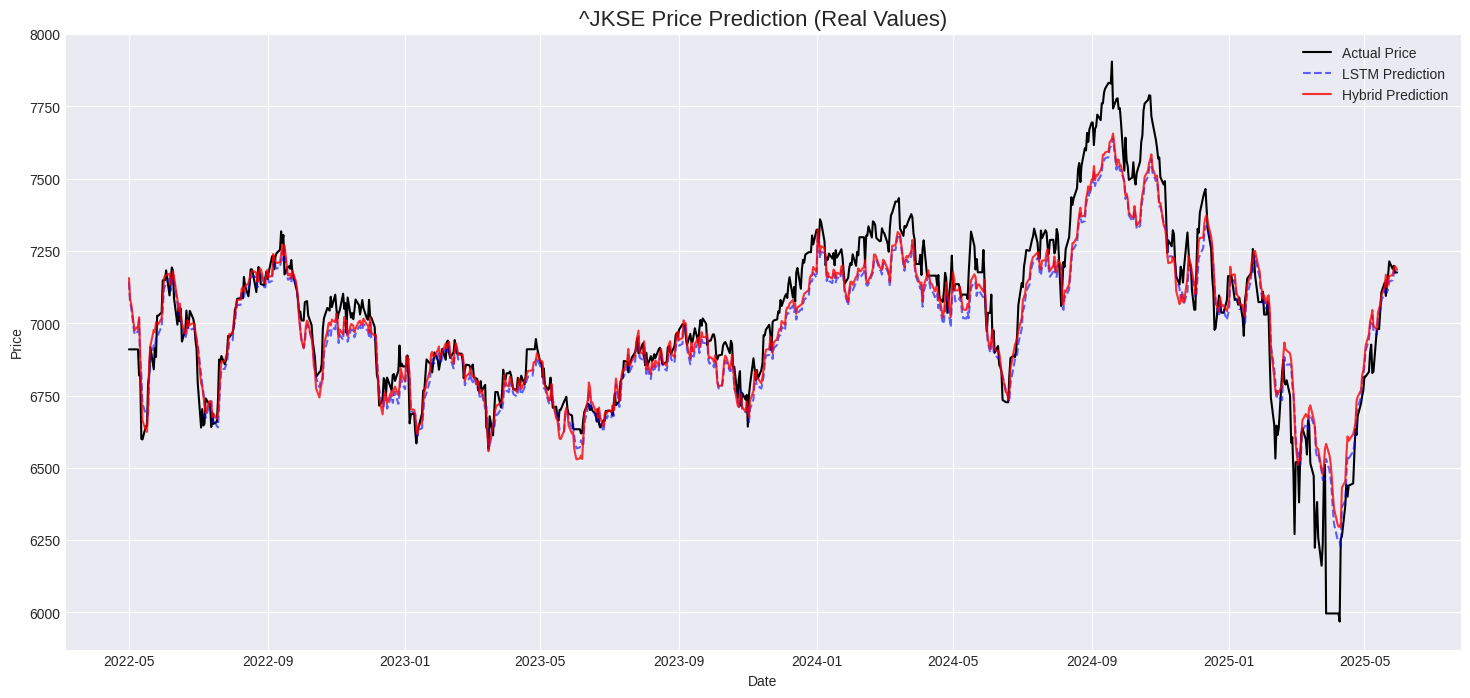


--- Model Evaluation Metrics (Scaled Data) ---

LSTM:
  RMSE: 0.022372
  MAE: 0.016698

Hybrid (LSTM + XGBoost Residual):
  RMSE: 0.021335
  MAE: 0.015148


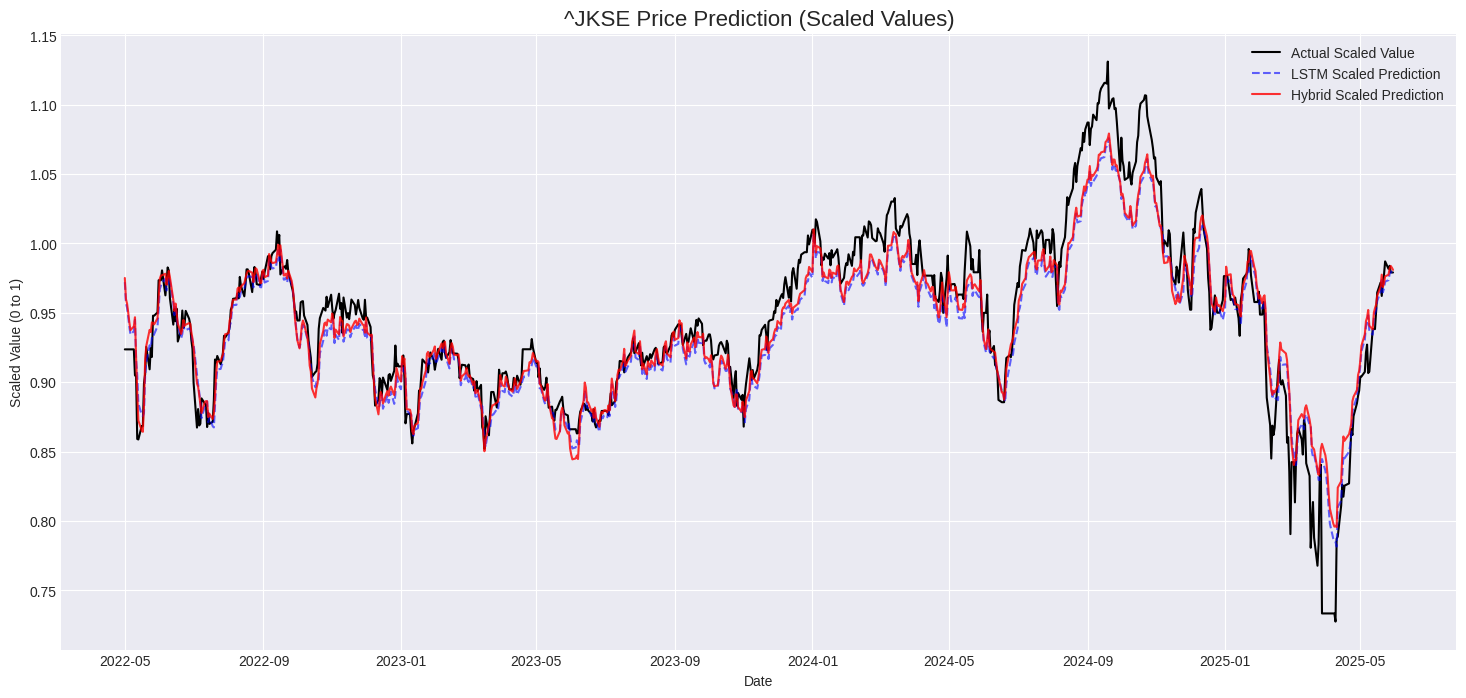


Block 8: Evaluation and Visualization Complete.


In [ ]:
# ===================================================================
# Block 8: Evaluation & Visualization of Hybrid Model
# ===================================================================
logging.info("Evaluating and visualizing models...")

# 1. Get base predictions from LSTM on the test set
lstm_pred_scaled = lstm_model.predict(X_test_seq).flatten()

# 2. Get the predicted residuals from XGBoost on the test set
xgb_pred_residuals = xgb_residual_model.predict(X_test_flat)

# 3. Create the final hybrid prediction by adding the base prediction and the predicted error
hybrid_pred_scaled = lstm_pred_scaled + xgb_pred_residuals

# --- Evaluation on Inverse-Transformed (Real Price) Data ---
num_features = feature_df.shape[1]

def inverse_transform(data, target_idx, scaler_obj, n_features):
    dummy_array = np.zeros((len(data), n_features))
    dummy_array[:, target_idx] = data.flatten()
    return scaler_obj.inverse_transform(dummy_array)[:, target_idx]

y_test_inv = inverse_transform(y_test, target_col_index, scaler, num_features)
lstm_pred_inv = inverse_transform(lstm_pred_scaled, target_col_index, scaler, num_features)
hybrid_pred_inv = inverse_transform(hybrid_pred_scaled, target_col_index, scaler, num_features)

# If differencing was applied, we need to reverse it
if was_differenced:
    # Get the last actual price from the training set to start the cumulative sum
    last_train_price = raw_df[TARGET_TICKER].iloc[train_df.index[-1]]
    
    # Inverse difference by taking the cumulative sum and adding the last known price
    y_test_inv = last_train_price + y_test_inv.cumsum()
    lstm_pred_inv = last_train_price + lstm_pred_inv.cumsum()
    hybrid_pred_inv = last_train_price + hybrid_pred_inv.cumsum()


def smape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100

metrics_inv = {
    'LSTM': {'RMSE': np.sqrt(mean_squared_error(y_test_inv, lstm_pred_inv)), 'MAE': mean_absolute_error(y_test_inv, lstm_pred_inv), 'sMAPE': smape(y_test_inv, lstm_pred_inv)},
    'Hybrid (LSTM + XGBoost Residual)': {'RMSE': np.sqrt(mean_squared_error(y_test_inv, hybrid_pred_inv)), 'MAE': mean_absolute_error(y_test_inv, hybrid_pred_inv), 'sMAPE': smape(y_test_inv, hybrid_pred_inv)}
}
print("\n--- Model Evaluation Metrics (Real Price) ---")
for model_name, m in metrics_inv.items():
    print(f"\n{model_name}:")
    for metric_name, val in m.items():
        print(f"  {metric_name}: {val:.4f}")

test_dates = test_df.index

# Plot results for real price
plt.figure(figsize=(18, 8))
plt.plot(test_dates, y_test_inv, color='black', label='Actual Price')
plt.plot(test_dates, lstm_pred_inv, color='blue', linestyle='--', alpha=0.6, label='LSTM Prediction')
plt.plot(test_dates, hybrid_pred_inv, color='red', linestyle='-', alpha=0.8, label='Hybrid Prediction')
plt.title(f'{TARGET_TICKER} Price Prediction (Real Values)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# --- Evaluation on Scaled (0-1) Data ---
metrics_scaled = {
    'LSTM': {'RMSE': np.sqrt(mean_squared_error(y_test, lstm_pred_scaled)), 'MAE': mean_absolute_error(y_test, lstm_pred_scaled)},
    'Hybrid (LSTM + XGBoost Residual)': {'RMSE': np.sqrt(mean_squared_error(y_test, hybrid_pred_scaled)), 'MAE': mean_absolute_error(y_test, hybrid_pred_scaled)}
}
print("\n--- Model Evaluation Metrics (Scaled Data) ---")
for model_name, m in metrics_scaled.items():
    print(f"\n{model_name}:")
    for metric_name, val in m.items():
        print(f"  {metric_name}: {val:.6f}")

# Plot results for scaled data
plt.figure(figsize=(18, 8))
plt.plot(test_dates, y_test, color='black', label='Actual Scaled Value')
plt.plot(test_dates, lstm_pred_scaled, color='blue', linestyle='--', alpha=0.6, label='LSTM Scaled Prediction')
plt.plot(test_dates, hybrid_pred_scaled, color='red', linestyle='-', alpha=0.8, label='Hybrid Scaled Prediction')
plt.title(f'{TARGET_TICKER} Price Prediction (Scaled Values)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Scaled Value (0 to 1)')
plt.legend()
plt.grid(True)
plt.show()

print("\nBlock 8: Evaluation and Visualization Complete.")

2025-07-06 19:51:06,453 - INFO - Performing SHAP analysis...


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


2025-07-06 19:51:10,038 - INFO - num_full_subsets = 0
2025-07-06 19:51:10,045 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

   7/7513 ━━━━━━━━━━━━━━━━━━━━ 2:28 20ms/step

2025-07-06 19:51:14.862292: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1327008000 exceeds 10% of free system memory.


7513/7513 ━━━━━━━━━━━━━━━━━━━━ 99s 13ms/step


2025-07-06 19:52:58,577 - INFO - np.sum(w_aug) = np.float64(1379.9999999999998)
2025-07-06 19:52:58,579 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-07-06 19:52:58,952 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.04672398, 0.        ,
       0.        ])
  4%|▍         | 1/25 [01:52<45:02, 112.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


2025-07-06 19:53:01,043 - INFO - num_full_subsets = 0
2025-07-06 19:53:01,048 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

   9/7513 ━━━━━━━━━━━━━━━━━━━━ 1:44 14ms/step

2025-07-06 19:53:06.172235: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1327008000 exceeds 10% of free system memory.


7513/7513 ━━━━━━━━━━━━━━━━━━━━ 99s 13ms/step


2025-07-06 19:54:49,659 - INFO - np.sum(w_aug) = np.float64(1379.9999999999998)
2025-07-06 19:54:49,660 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-07-06 19:54:50,011 - INFO - phi = array([0.       , 0.       , 0.       , ..., 0.0451941, 0.       ,
       0.       ])
  8%|▊         | 2/25 [03:43<42:46, 111.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


2025-07-06 19:54:52,421 - INFO - num_full_subsets = 0
2025-07-06 19:54:52,431 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

   4/7513 ━━━━━━━━━━━━━━━━━━━━ 2:28 20ms/step

2025-07-06 19:54:58.150785: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1327008000 exceeds 10% of free system memory.


7513/7513 ━━━━━━━━━━━━━━━━━━━━ 110s 15ms/step


2025-07-06 19:56:51,937 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 19:56:51,938 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 19:56:52,295 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.04271142, 0.        ,
       0.        ])
 12%|█▏        | 3/25 [05:45<42:43, 116.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


2025-07-06 19:56:53,990 - INFO - num_full_subsets = 0
2025-07-06 19:56:53,996 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

   5/7513 ━━━━━━━━━━━━━━━━━━━━ 1:58 16ms/step

2025-07-06 19:56:56.916868: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1327008000 exceeds 10% of free system memory.


7513/7513 ━━━━━━━━━━━━━━━━━━━━ 120s 16ms/step


2025-07-06 19:59:01,140 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 19:59:01,142 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 19:59:01,547 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03991624, 0.        ,
       0.        ])
 16%|█▌        | 4/25 [07:55<42:31, 121.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


2025-07-06 19:59:03,634 - INFO - num_full_subsets = 0
2025-07-06 19:59:03,641 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

  10/7513 ━━━━━━━━━━━━━━━━━━━━ 1:30 12ms/step

2025-07-06 19:59:07.173531: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1327008000 exceeds 10% of free system memory.


7513/7513 ━━━━━━━━━━━━━━━━━━━━ 111s 15ms/step


2025-07-06 20:01:02,097 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:01:02,099 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:01:02,450 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.04371632, 0.        ,
       0.        ])
 20%|██        | 5/25 [09:55<40:25, 121.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


2025-07-06 20:01:04,021 - INFO - num_full_subsets = 0
2025-07-06 20:01:04,026 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 103s 14ms/step


2025-07-06 20:02:52,170 - INFO - np.sum(w_aug) = np.float64(1380.0000000000002)
2025-07-06 20:02:52,172 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-07-06 20:02:52,487 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03784916, 0.        ,
       0.        ])
 24%|██▍       | 6/25 [11:46<37:12, 117.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


2025-07-06 20:02:54,065 - INFO - num_full_subsets = 0
2025-07-06 20:02:54,071 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 96s 13ms/step


2025-07-06 20:04:35,582 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:04:35,583 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999998)
2025-07-06 20:04:35,927 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.04059113, 0.        ,
       0.        ])
 28%|██▊       | 7/25 [13:29<33:51, 112.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


2025-07-06 20:04:37,534 - INFO - num_full_subsets = 0
2025-07-06 20:04:37,539 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 98s 13ms/step


2025-07-06 20:06:21,107 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:06:21,108 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:06:21,482 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.04125755, 0.        ,
       0.        ])
 32%|███▏      | 8/25 [15:15<31:20, 110.59s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


2025-07-06 20:06:23,652 - INFO - num_full_subsets = 0
2025-07-06 20:06:23,658 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 96s 13ms/step


2025-07-06 20:08:07,085 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:08:07,086 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:08:07,402 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03669431, 0.        ,
       0.        ])
 36%|███▌      | 9/25 [17:00<29:05, 109.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


2025-07-06 20:08:09,114 - INFO - num_full_subsets = 0
2025-07-06 20:08:09,119 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 214s 28ms/step


2025-07-06 20:12:34,998 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:12:35,006 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:12:36,527 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03652894, 0.        ,
       0.        ])
 40%|████      | 10/25 [21:30<39:38, 158.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


2025-07-06 20:12:48,375 - INFO - num_full_subsets = 0
2025-07-06 20:12:48,388 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 351s 47ms/step


2025-07-06 20:19:00,402 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:19:00,404 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:19:01,459 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03786497, 0.        ,
       0.        ])
 44%|████▍     | 11/25 [27:54<53:08, 227.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


2025-07-06 20:19:05,377 - INFO - num_full_subsets = 0
2025-07-06 20:19:05,384 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 191s 25ms/step


2025-07-06 20:22:28,851 - INFO - np.sum(w_aug) = np.float64(1379.9999999999998)
2025-07-06 20:22:28,853 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-07-06 20:22:29,280 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03457568, 0.        ,
       0.        ])
 48%|████▊     | 12/25 [31:22<48:02, 221.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025-07-06 20:22:32,118 - INFO - num_full_subsets = 0
2025-07-06 20:22:32,129 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 181s 24ms/step


2025-07-06 20:25:50,157 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:25:50,159 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:25:50,614 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03615419, 0.        ,
       0.        ])
 52%|█████▏    | 13/25 [34:44<43:06, 215.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


2025-07-06 20:25:53,575 - INFO - num_full_subsets = 0
2025-07-06 20:25:53,586 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 160s 21ms/step


2025-07-06 20:28:47,152 - INFO - np.sum(w_aug) = np.float64(1379.9999999999998)
2025-07-06 20:28:47,153 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999997)
2025-07-06 20:28:47,607 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03496981, 0.        ,
       0.        ])
 56%|█████▌    | 14/25 [37:41<37:23, 203.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025-07-06 20:28:50,845 - INFO - num_full_subsets = 0
2025-07-06 20:28:50,852 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 151s 20ms/step


2025-07-06 20:31:38,497 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:31:38,498 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:31:39,021 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03610718, 0.        ,
       0.        ])
 60%|██████    | 15/25 [40:32<32:21, 194.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


2025-07-06 20:31:41,769 - INFO - num_full_subsets = 0
2025-07-06 20:31:41,775 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 155s 21ms/step


2025-07-06 20:34:27,398 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:34:27,400 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:34:27,859 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03565297, 0.        ,
       0.        ])
 64%|██████▍   | 16/25 [43:21<27:58, 186.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


2025-07-06 20:34:30,214 - INFO - num_full_subsets = 0
2025-07-06 20:34:30,223 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 165s 22ms/step


2025-07-06 20:37:25,827 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:37:25,829 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:37:26,381 - INFO - phi = array([0., 0., 0., ..., 0., 0., 0.])
 68%|██████▊   | 17/25 [46:19<24:32, 184.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


2025-07-06 20:37:28,870 - INFO - num_full_subsets = 0
2025-07-06 20:37:28,879 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 150s 20ms/step


2025-07-06 20:40:07,729 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:40:07,731 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999998)
2025-07-06 20:40:08,078 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03737914, 0.        ,
       0.        ])
 72%|███████▏  | 18/25 [49:01<20:41, 177.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


2025-07-06 20:40:10,307 - INFO - num_full_subsets = 0
2025-07-06 20:40:10,313 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 153s 20ms/step


2025-07-06 20:42:53,261 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:42:53,264 - INFO - np.sum(self.kernelWeights) = np.float64(1.0000000000000002)
2025-07-06 20:42:53,904 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.04062735, 0.        ,
       0.        ])
 76%|███████▌  | 19/25 [51:47<17:23, 173.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


2025-07-06 20:42:56,636 - INFO - num_full_subsets = 0
2025-07-06 20:42:56,646 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 154s 20ms/step


2025-07-06 20:45:41,449 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:45:41,450 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999999)
2025-07-06 20:45:41,885 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.04009484, 0.        ,
       0.        ])
 80%|████████  | 20/25 [54:35<14:20, 172.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


2025-07-06 20:45:43,737 - INFO - num_full_subsets = 0
2025-07-06 20:45:43,744 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 141s 19ms/step


2025-07-06 20:48:14,811 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:48:14,813 - INFO - np.sum(self.kernelWeights) = np.float64(0.9999999999999996)
2025-07-06 20:48:15,378 - INFO - phi = array([0.       , 0.       , 0.       , ..., 0.0415179, 0.       ,
       0.       ])
 84%|████████▍ | 21/25 [57:08<11:06, 166.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025-07-06 20:48:18,507 - INFO - num_full_subsets = 0
2025-07-06 20:48:18,514 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 134s 18ms/step


2025-07-06 20:50:40,101 - INFO - np.sum(w_aug) = np.float64(1380.0000000000002)
2025-07-06 20:50:40,103 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:50:40,514 - INFO - phi = array([0.       , 0.       , 0.       , ..., 0.0405208, 0.       ,
       0.       ])
 88%|████████▊ | 22/25 [59:34<08:00, 160.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


2025-07-06 20:50:43,281 - INFO - num_full_subsets = 0
2025-07-06 20:50:43,289 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 133s 18ms/step


2025-07-06 20:53:04,889 - INFO - np.sum(w_aug) = np.float64(1379.9999999999998)
2025-07-06 20:53:04,890 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:53:05,516 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.03986566, 0.        ,
       0.        ])
 92%|█████████▏| 23/25 [1:01:59<05:11, 155.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


2025-07-06 20:53:07,886 - INFO - num_full_subsets = 0
2025-07-06 20:53:07,893 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 140s 19ms/step


2025-07-06 20:55:35,707 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:55:35,709 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:55:36,214 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.05025258, 0.        ,
       0.        ])
 96%|█████████▌| 24/25 [1:04:29<02:34, 154.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


2025-07-06 20:55:39,268 - INFO - num_full_subsets = 0
2025-07-06 20:55:39,276 - INFO - remaining_weight_vector = array([0.12816432, 0.06412867, 0.04278349, 0.03211094, 0.02570743,
       0.02143845, 0.0183892 , 0.01610228, 0.01432358, 0.01290063,
       0.01173641, 0.01076624, 0.00994534, 0.00924172, 0.00863192,
       0.00809836, 0.00762758, 0.00720911, 0.0068347 , 0.00649774,
       0.00619288, 0.00591574, 0.0056627 , 0.00543076, 0.00521738,
       0.00502041, 0.00483804, 0.00466871, 0.00451105, 0.00436392,
       0.00422628, 0.00409724, 0.00397603, 0.00386196, 0.0037544 ,
       0.00365283, 0.00355675, 0.00346573, 0.00337939, 0.00329736,
       0.00321934, 0.00314504, 0.0030742 , 0.00300658, 0.00294197,
       0.00288017, 0.002821  , 0.0027643 , 0.00270993, 0.00265772,
       0.00260757, 0.00255935, 0.00251295, 0.00246828, 0.00242523,
       0.00238372, 0.00234367, 0.00230501, 0.00226765, 0.00223155,
       0.00219663, 0.00216284, 0.00213013, 0.00209844, 0.00206772,
       0.0020379

7513/7513 ━━━━━━━━━━━━━━━━━━━━ 147s 20ms/step


2025-07-06 20:58:16,013 - INFO - np.sum(w_aug) = np.float64(1380.0)
2025-07-06 20:58:16,015 - INFO - np.sum(self.kernelWeights) = np.float64(1.0)
2025-07-06 20:58:16,574 - INFO - phi = array([0.        , 0.        , 0.        , ..., 0.04568274, 0.        ,
       0.        ])
100%|██████████| 25/25 [1:07:10<00:00, 161.20s/it]



--- SHAP Analysis for LSTM ---


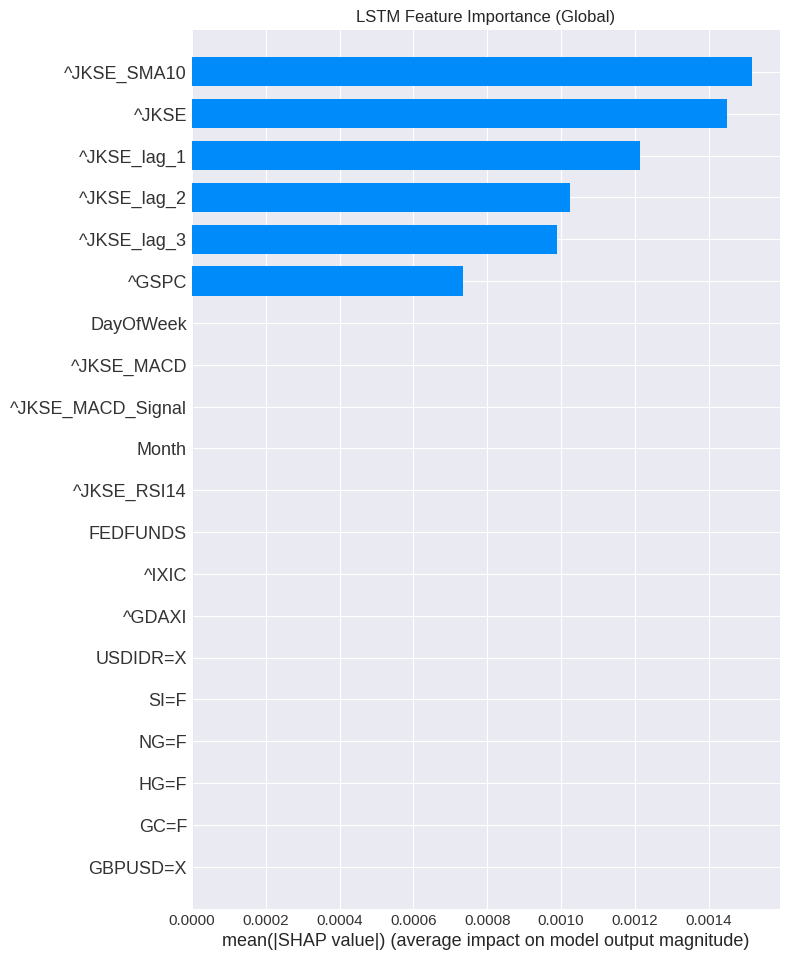


--- SHAP Analysis for XGBoost Residual Model ---


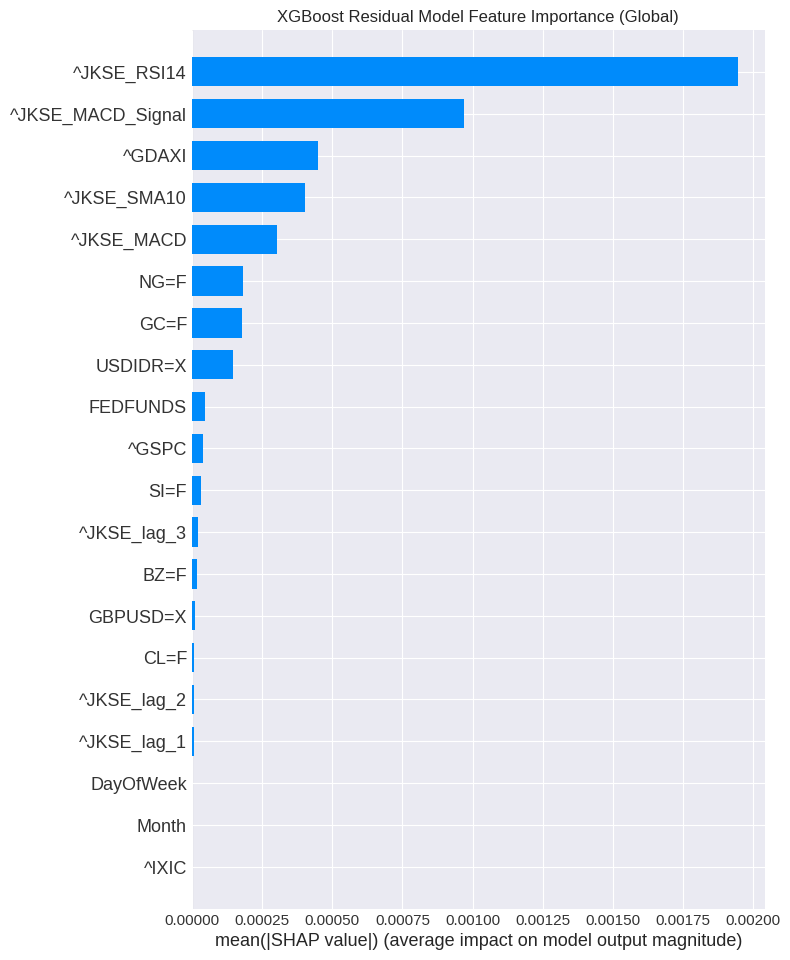


--- XGBoost Residual Model Local Explanation (Force Plot) ---


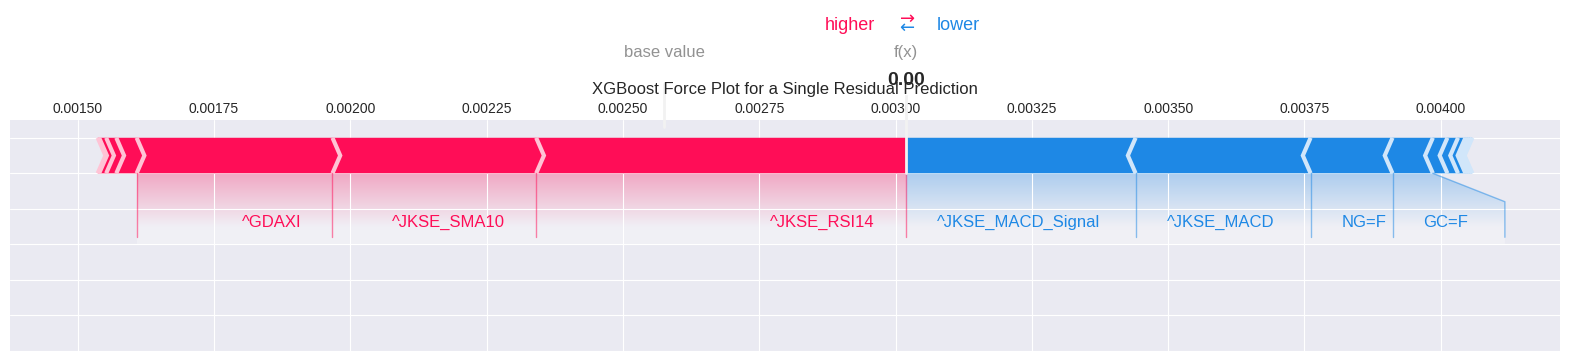


Block 9: SHAP Analysis Complete.


In [10]:
# ===================================================================
# Block 9: SHAP Analysis
# ===================================================================
logging.info("Performing SHAP analysis...")

# --- SHAP for LSTM ---
background_data_2d = X_train_seq[np.random.choice(X_train_seq.shape[0], 50, replace=False)].reshape(-1, X_train_seq.shape[1] * X_train_seq.shape[2])
def lstm_predict_wrapper(data_2d):
    data_3d = data_2d.reshape(-1, X_train_seq.shape[1], X_train_seq.shape[2])
    return lstm_model.predict(data_3d)
explainer_lstm = shap.KernelExplainer(lstm_predict_wrapper, background_data_2d)
X_test_seq_2d = X_test_seq[:25].reshape(-1, X_test_seq.shape[1] * X_test_seq.shape[2])
shap_values_lstm = explainer_lstm.shap_values(X_test_seq_2d)
shap_values_lstm_reshaped = shap_values_lstm.reshape(-1, X_test_seq.shape[2])

print("\n--- SHAP Analysis for LSTM ---")
shap.summary_plot(shap_values_lstm_reshaped, features=feature_df.columns, plot_type="bar", show=False)
plt.title("LSTM Feature Importance (Global)")
plt.show()

# --- SHAP for XGBoost Residual Model ---
explainer_xgb = shap.Explainer(xgb_residual_model)
shap_values_xgb = explainer_xgb(X_test_flat)
# The features for the residual model do not include the target or the LSTM prediction
xgb_feature_names = feature_df.drop(columns=TARGET_TICKER).columns.tolist()


print("\n--- SHAP Analysis for XGBoost Residual Model ---")
shap.summary_plot(shap_values_xgb, feature_names=xgb_feature_names, plot_type="bar", max_display=20, show=False)
plt.title("XGBoost Residual Model Feature Importance (Global)")
plt.show()

print("\n--- XGBoost Residual Model Local Explanation (Force Plot) ---")
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb.values[0,:], feature_names=xgb_feature_names, matplotlib=True, show=False)
plt.title("XGBoost Force Plot for a Single Residual Prediction")
plt.show()
print("\nBlock 9: SHAP Analysis Complete.")



In [11]:
# ===================================================================
# Block 10: Save Models
# ===================================================================
output_dir = Path("financial_models")
output_dir.mkdir(exist_ok=True)
lstm_model.save(output_dir / "lstm_model.keras")
joblib.dump(xgb_residual_model, output_dir / "xgb_residual_model.pkl")
joblib.dump(scaler, output_dir / "scaler.pkl")
logging.info(f"Models and scaler saved to '{output_dir}' directory.")
print("\nBlock 10: Model Saving Complete.")

2025-07-06 20:58:19,374 - INFO - Models and scaler saved to 'financial_models' directory.



Block 10: Model Saving Complete.
